Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau

from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

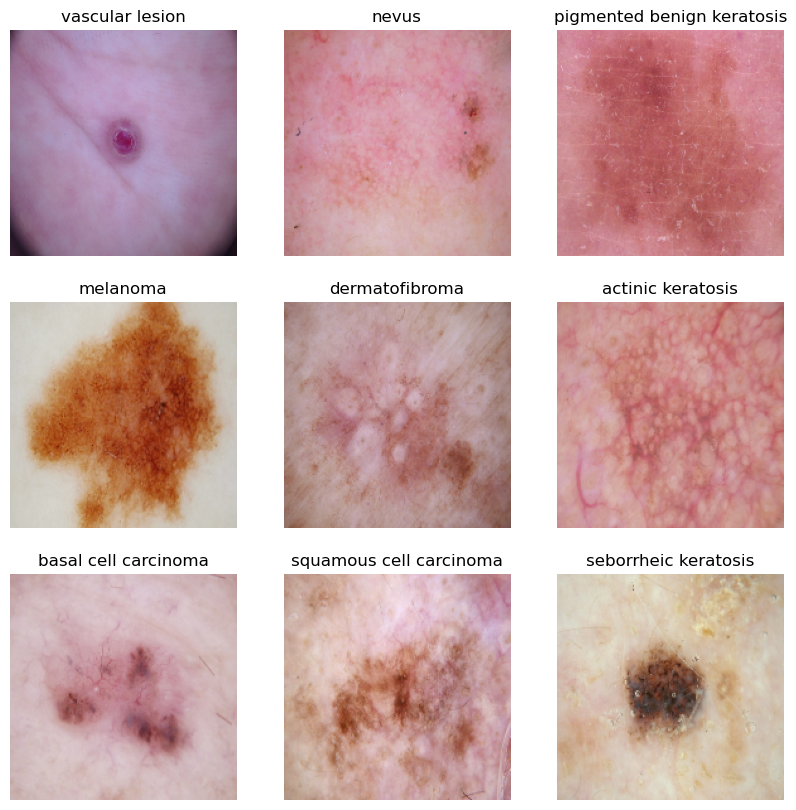

In [15]:
class_images = {}

# Iterate over the dataset to extract one image per class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if class_name not in class_images:
            class_images[class_name] = img
        if len(class_images) == len(class_names):
            break
    if len(class_images) == len(class_names):
        break

# Plot the images
plt.figure(figsize=(10, 10))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
# CNN model
input_shape = (img_height,img_width,3)

model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Flatten())

model.add(layers.Dense(128,activation='relu'))

model.add(layers.Dense(len(class_names),activation='softmax'))

C:\Users\naray\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [21]:
### Todo, choose an appropirate optimiser and loss function
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


C:\Users\naray\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.2338 - loss: 2.2408 - val_accuracy: 0.2931 - val_loss: 1.8641
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.3488 - loss: 1.7809 - val_accuracy: 0.4295 - val_loss: 1.6226
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.3682 - loss: 1.7474 - val_accuracy: 0.4318 - val_loss: 1.5849
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.4739 - loss: 1.5189 - val_accuracy: 0.4989 - val_loss: 1.4729
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.5196 - loss: 1.3674 - val_accuracy: 0.5190 - val_loss: 1.4137
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - accuracy: 0.5217 - loss: 1.3201 - val_accuracy: 0.5011 - val_loss: 1.4781
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.5527 - loss: 1.2599 - val_accuracy: 0.5034 - val_loss: 1.4628
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - accuracy: 0.5955 - loss: 1.2086 - val_accuracy: 0.530

### Visualizing training results

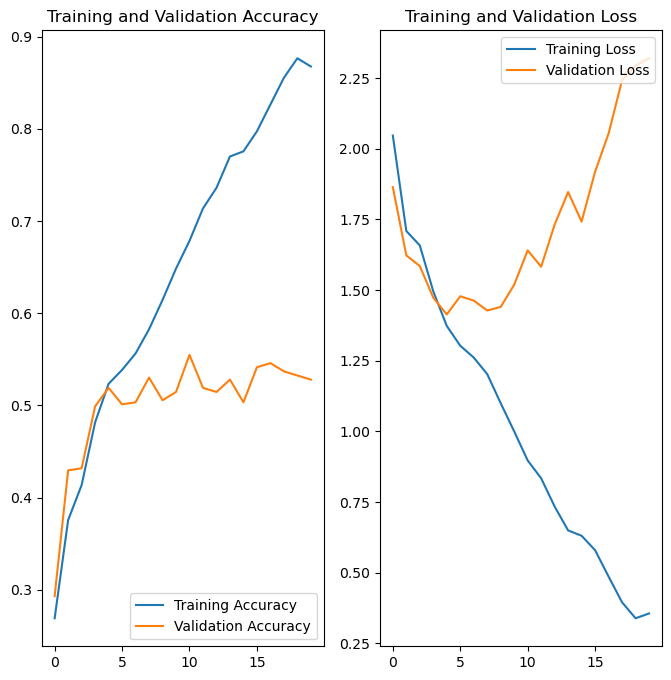

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Observations:

* The model's training accuracy shows a steady increase of upto 88%, while validation accuracy remains consistently around 53%.

* This clearly shows the presence of overfitting. To resolve this issue, augmentation techniques need to be employed. Since there is limited training data available, we need to generate new samples by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

In [30]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

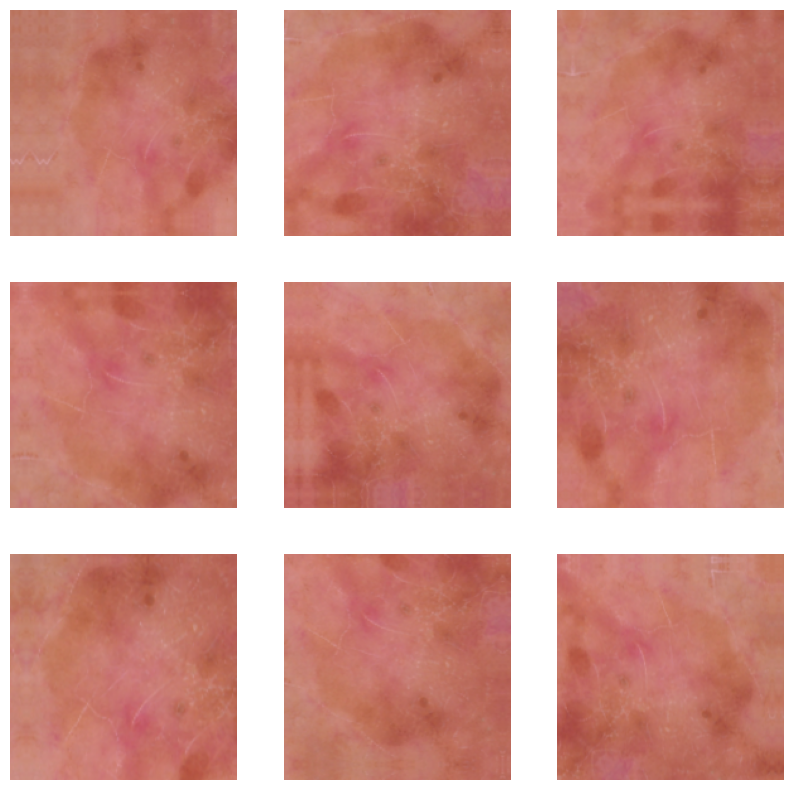

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [40]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model2 = Sequential()

model2.add(data_augmentation)
model2.add(layers.Rescaling(1./255,input_shape=input_shape))
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
model2.add(layers.Flatten())

model2.add(layers.Dense(128,activation='relu'))

model2.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [48]:
## Your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.2, verbose=1, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model2.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [50]:
## Your code goes here, note: train your model for 20 epochs
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[learn_control])

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.1981 - loss: 2.8233 - val_accuracy: 0.2819 - val_loss: 2.0026 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3237 - loss: 1.8903 - val_accuracy: 0.3311 - val_loss: 1.8390 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.3581 - loss: 1.7277 - val_accuracy: 0.4251 - val_loss: 1.6396 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.4219 - loss: 1.6116 - val_accuracy: 0.3714 - val_loss: 1.7477 - learning_rate: 0.0010
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.4732 - loss: 1.4896 - val_accuracy: 0.4676 - val_loss: 1.5539 - learning_rate: 0.0010
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - accuracy: 0.4707 - loss: 1.4651 - val_accuracy: 0.5145 - val_loss: 1.4412 - learning_rate: 0.0010
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.4963 - loss: 1.

### Visualizing the results

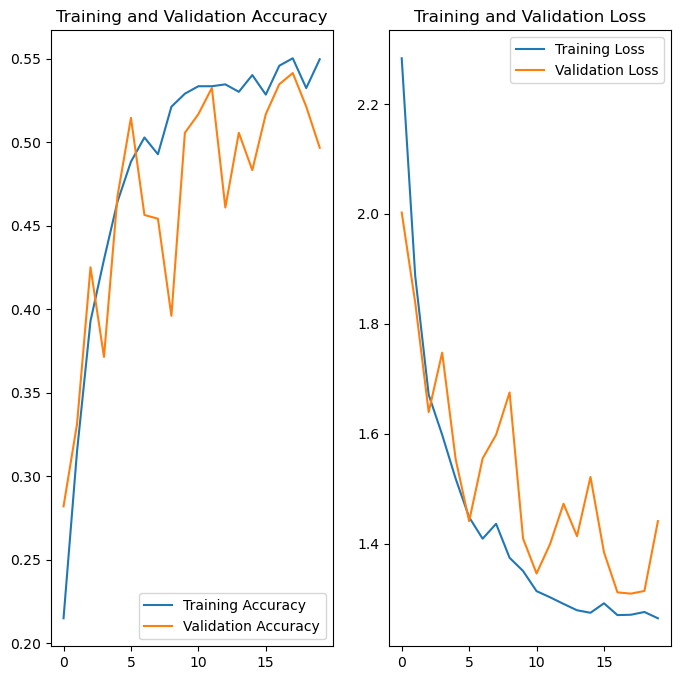

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observations:

* The issue of overfitting has been effectively addressed by leveraging augmented data, and both raining and validation accuracy of the above mentioned model fall within a similar range.

* But now the training and validation data are showing poor performance, indicating that the model is now exhibiting underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [54]:
# Get number of images in each classes
class_diff = []
for i in range(len(class_names)):
    name = class_names[i]
    number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
    class_diff.append({'Class Name': name, 'Count': number})

class_diff = pd.DataFrame(class_diff)
total_count = class_diff['Count'].sum()  # Sum of all class counts
class_diff['Percentage'] = round((class_diff['Count'] / total_count) * 100, 2)  # Add percentage column

class_diff

,Class Name,Count,Percentage
0,actinic keratosis,114,5.09
1,basal cell carcinoma,376,16.79
2,dermatofibroma,95,4.24
3,melanoma,438,19.56
4,nevus,357,15.94
5,pigmented benign keratosis,462,20.63
6,seborrheic keratosis,77,3.44
7,squamous cell carcinoma,181,8.08
8,vascular lesion,139,6.21


<BarContainer object of 9 artists>

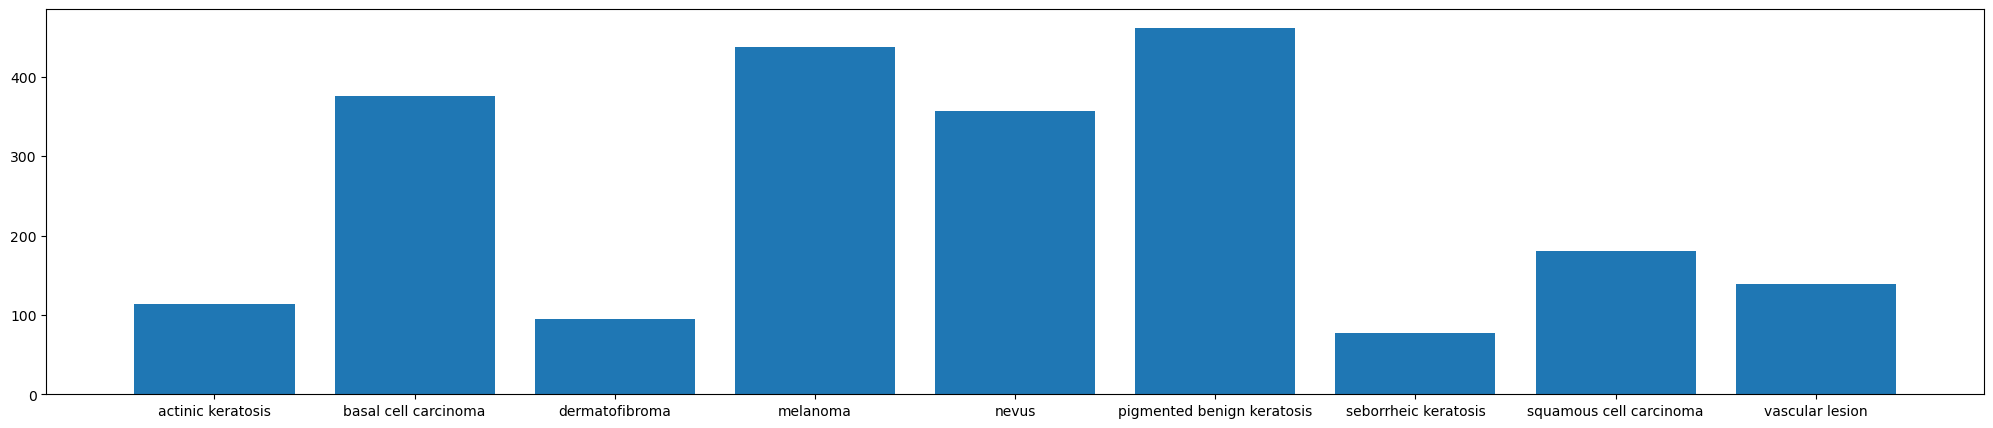

In [56]:
# Ploting the count of images in each Class
plt.figure(figsize=(25,5))
plt.bar(x='Class Name',height='Count', data=class_diff)

<BarContainer object of 9 artists>

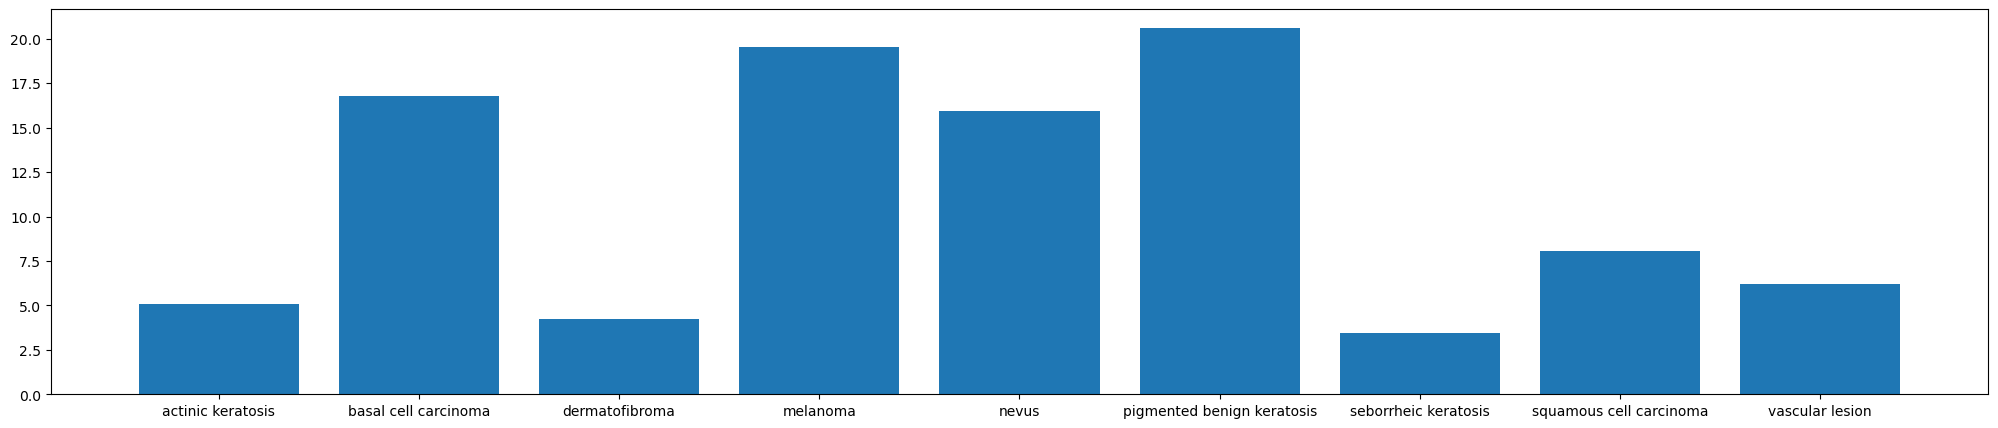

In [58]:
# Ploting the percentage of images in each Class
plt.figure(figsize=(25,5))
plt.bar(x='Class Name',height='Percentage', data=class_diff)

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


Observations:

There is a clear class imbalance within the training data.

* The class "seborrheic keratosis" comprises the smallest proportion of samples, accounting for approximately 3.44%.

* "pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately 20.63% and 19.56% of the data, respectively.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [60]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [62]:
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20ECB2D9EB0>: 100%|█| 500/500 [00:01<00:


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20ECA11FDD0>: 100%|█| 500/500 [00:01<00:00, 310.82 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20ECA058B90>: 100%|█| 500/500 [00:01<00:00, 304.80 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x20ECD9D6480>: 100%|█| 500/500 [00:09<00


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20ECA11E510>: 100%|█| 500/500 [00:08<00:00, 61.86 Samples/


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20ECB3D2240>: 100%|█| 500/500 [00:01<00:00, 292.60 Samples


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x20ECA1042F0>: 100%|█| 500/500 [00:03<00:00, 126.63 Sample


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x20ECB3D1010>: 100%|█| 500/500 [00:01<00:


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x20ECB300860>: 100%|█| 500/500 [00:01<00:00, 284.55 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [64]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [66]:
path_list_new  = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:10]

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_22203a97-239d-4983-9068-5f24eae0d0f8.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_7af53151-d2b8-4c24-b2a2-08166ccd3f62.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_276709ec-ec99-4604-b98d-4cba66bdb74d.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a562f61a-d31b-49ee-90fd-78b1385d1587.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_ee94ff9a-a3cf-41e8-b825-024d6c8fd7ad.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [68]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:10]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [70]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [72]:
path_list=[]
lesion_list=[]
for name in class_names:
  for file in data_dir_train.glob(name+'/*.jpg'):
    path_list.append(str(file))
    lesion_list.append(name)

dataframe_dict_original=dict(zip(path_list,lesion_list))
original_df=pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])

In [76]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

In [78]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

Label
pigmented benign keratosis    14.28
melanoma                      13.92
basal cell carcinoma          13.00
nevus                         12.72
squamous cell carcinoma       10.11
vascular lesion                9.48
actinic keratosis              9.11
dermatofibroma                 8.83
seborrheic keratosis           8.56
Name: proportion, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [80]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [121]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [123]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [154]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [125]:
model3 = Sequential([
    layers.Rescaling(1./255,input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(len(class_names),activation='softmax')
])

C:\Users\naray\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [131]:
opt=tf.keras.optimizers.Adam()
model3.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 178, 178, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 87, 87, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 118336)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      15,147,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,168,585 (57.86 MB)

 Trainable params: 15,168,137 (57.86 MB)

 Non-trainable params: 448 (1.75 KB)

#### **Todo:**  Train your model

In [135]:
epochs = 30
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,callbacks=[learn_control])

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 485ms/step - accuracy: 0.5932 - loss: 1.1517 - val_accuracy: 0.1782 - val_loss: 2.6206 - learning_rate: 0.0010
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 487ms/step - accuracy: 0.6771 - loss: 0.9344 - val_accuracy: 0.4551 - val_loss: 1.6312 - learning_rate: 0.0010
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 487ms/step - accuracy: 0.7617 - loss: 0.7263 - val_accuracy: 0.4618 - val_loss: 1.5054 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 480ms/step - accuracy: 0.8080 - loss: 0.5547 - val_accuracy: 0.4180 - val_loss: 1.8498 - learning_rate: 0.0010
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 480ms/step - accuracy: 0.8704 - loss: 0.3946 - val_accuracy: 0.7127 - val_loss: 0.7894 - learning_rate: 0.0010
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 479ms/step - accuracy: 0.9041 - loss: 0.2967 - val_accuracy: 0.6125 - val_loss: 1.1832 - learning_rate: 0.0010
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 480ms/step - accuracy: 0.9

#### **Todo:**  Visualize the model results

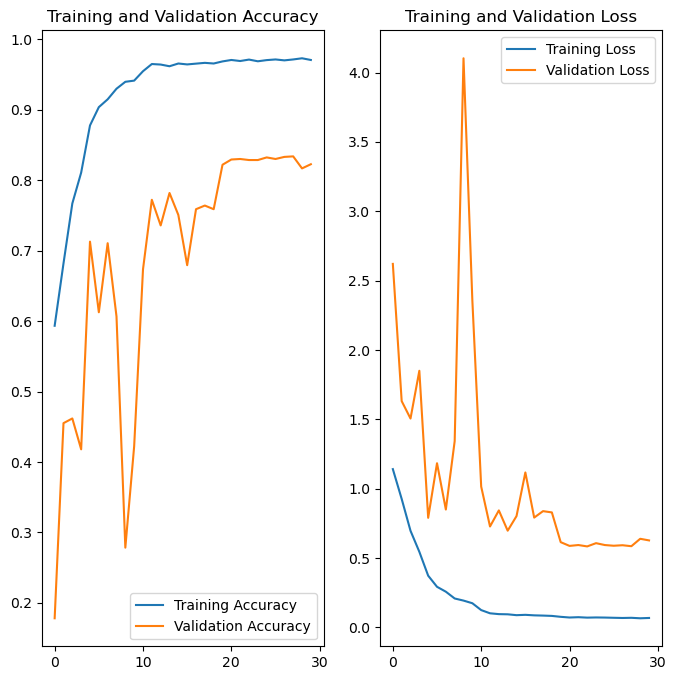

In [137]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations:

* The model's training accuracy shows a steady increase of upto 97%, while validation accuracy remains around 82%.
* Even though the validation accuracy is good, there seems to be a bit of overfitting in this model. We will remove the batch normalization and try it out again.l.

#### Todo: Create your model (without normalization)

In [166]:
model4 = Sequential([
    layers.Rescaling(1./255,input_shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names),activation='softmax')
])

C:\Users\naray\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [168]:
opt=tf.keras.optimizers.Adam()
model4.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model4.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [170]:
epochs = 30
history = model4.fit(train_ds,epochs=epochs,validation_data=val_ds)

Epoch 1/30


C:\Users\naray\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 170ms/step - accuracy: 0.1703 - loss: 2.1997 - val_accuracy: 0.3133 - val_loss: 1.8332
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 169ms/step - accuracy: 0.3295 - loss: 1.7413 - val_accuracy: 0.4506 - val_loss: 1.5163
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - accuracy: 0.3933 - loss: 1.5776 - val_accuracy: 0.4989 - val_loss: 1.3321
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - accuracy: 0.4294 - loss: 1.4774 - val_accuracy: 0.4863 - val_loss: 1.3112
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step - accuracy: 0.4455 - loss: 1.4366 - val_accuracy: 0.5085 - val_loss: 1.2784
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 29s 174ms/step - accuracy: 0.4795 - loss: 1.3520 - val_accuracy: 0.5612 - val_loss: 1.1452
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.5042 - loss: 1.2934 - val_accuracy: 0.5449 - val_loss: 1.1648
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - accuracy: 0.5444 - loss: 1.1581 - val

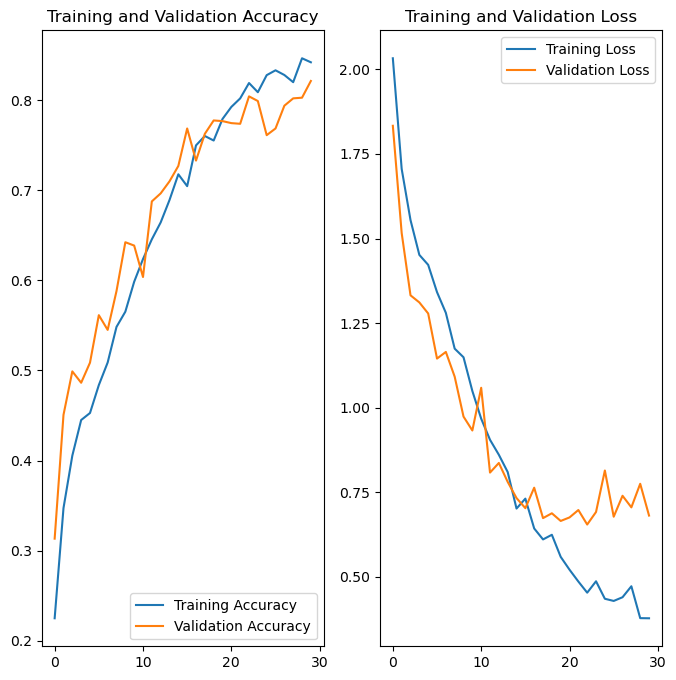

In [172]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Observations:
* The final model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

* The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

* The training loss and validation loss are also not much different which is also a sign of good fit.

* The Validation accuracy is 0.82 which is good. The model is able to classify the image with 82% accuracy.

* Batch Normalization didn't help in enhancing the training and validation accuracy.